In [54]:
import os

wd = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/'
os.chdir(wd)

from TGB.tgb.linkproppred.dataset import LinkPropPredDataset

import requests
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import itertools
from itertools import combinations
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr
from matplotlib.lines import Line2D

import pickle
import random




In [114]:
dataset_name = 'tgbl-synthetic'

In [115]:
dataset = LinkPropPredDataset(name=dataset_name, root="datasets", preprocess=True)
data = dataset.full_data
data_df = pd.DataFrame([data['sources'], data['destinations'], data['timestamps'], data['edge_idxs'], data['edge_label'], data['edge_feat']]).T
data_df.columns = ['source', 'destination', 'timestamp', 'edge_idxs', 'edge_label', 'edge_feat']
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='s')
split_index = int(len(data_df) * 0.7)
split_index_val = int(len(data_df) * 0.85)
train_data_df = data_df.iloc[:split_index]
validation_data_df = data_df.iloc[split_index:split_index_val]
validation_threshold_timestamp = train_data_df['timestamp'].max()

Dataset tgbl-synthetic url not found, download not supported yet.
/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_synthetic/tgbl-synthetic_edgelist.csv
raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_synthetic
OUT_DF /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_synthetic/ml_tgbl-synthetic.pkl
OUT_EDGE_FEAT /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_synthetic/ml_tgbl-synthetic_edge.pkl
loading processed file


In [117]:
print(len(set(data_df['source']) | set(data_df['destination'])))

print(len(data_df['timestamp']))

8
5120


## TESTING CODE FROM KIRIL 


In [10]:

data_df = pd.DataFrame([data['sources'], data['destinations'], data['timestamps'], data['edge_idxs'], data['edge_label'], data['edge_feat']]).T
data_df.columns = ['source', 'destination', 'timestamp', 'edge_idxs', 'edge_label', 'edge_feat']
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='s')

# Add a column for the calendar week of the year
data_df['WeekOfYear'] = data_df['timestamp'].dt.isocalendar().week

# Group by 'Source' and 'Destination'
groups = data_df.groupby(['source', 'destination'])

# Function to check if events span multiple distinct weeks
def spans_multiple_weeks(group):
    # Check if there are multiple unique weeks
    return group['WeekOfYear'].nunique() > 1

# Apply the function to each group and get a boolean mask
mask = groups.apply(spans_multiple_weeks)

# Use the mask to filter groups that span multiple weeks
weekly_occurrences = data_df.groupby(['source', 'destination']).filter(spans_multiple_weeks)

weekly_occurrences

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,WeekOfYear


In [38]:

# Group by 'Source', 'Destination', and 'WeekOfYear', then count events per week
weekly_counts = weekly_occurrences.groupby(['source', 'destination', 'WeekOfYear']).size().reset_index(name='EventCount')

# To find out how many weeks each Source-Destination pair spans,
# first, group by 'Source' and 'Destination' only to get the unique weeks.
weeks_span = weekly_occurrences.groupby(['source', 'destination'])['WeekOfYear'].nunique().reset_index(name='WeeksSpan')

# Merging the weekly event counts with the span of weeks for each pair
result = pd.merge(weekly_counts, weeks_span, on=['source', 'destination'], how='left')
result

,source,destination,WeekOfYear,EventCount,WeeksSpan
0,1,8228,1,224,3
1,1,8228,2,7,3
2,1,8228,3,54,3
3,2,8229,1,17,5
4,2,8229,2,43,5
...,...,...,...,...,...
11394,7180,8574,5,1,2
11395,7181,8683,4,2,2
11396,7181,8683,5,12,2
11397,7195,8595,4,1,2


In [75]:
certain_date = validation_threshold_timestamp


# Step 1: Pairs with activity before the certain date
before_pairs = weekly_occurrences[weekly_occurrences['timestamp'] < certain_date].groupby(['source', 'destination']).ngroups

# Step 2: Pairs with activity after the certain date
after_pairs = weekly_occurrences[weekly_occurrences['timestamp'] > certain_date].groupby(['source', 'destination']).ngroups

# Combine steps 1 and 2 to find pairs active both before and after the certain date
active_both = weekly_occurrences.groupby(['source', 'destination']).filter(lambda x: (x['timestamp'] < certain_date).any() and (x['timestamp'] > certain_date).any())

# Step 3: Find unique source-destination pairs that meet both criteria
unique_active_both = active_both.groupby(['source', 'destination']).size().reset_index(name='EventCount')

# Now, you might want to join this with your result DataFrame to get the weekly counts and span information
# Assuming 'result' is the DataFrame with 'Source', 'Destination', 'WeekOfYear', 'EventCount', and 'WeeksSpan'
# Merge to get full information for the filtered pairs
final_result = pd.merge(unique_active_both[['source', 'destination']], weekly_occurrences, on=['source', 'destination'], how='left')

final_result

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,WeekOfYear
0,2,8229,1970-01-01 00:02:11,3,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1
1,2,8229,1970-01-01 00:02:33,5,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1
2,2,8229,1970-01-01 00:06:20,13,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1
3,2,8229,1970-01-01 00:06:42,19,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1
4,2,8229,1970-01-01 00:07:12,20,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1
...,...,...,...,...,...,...,...
91459,6515,8347,1970-01-22 11:54:27,109971,1.0,"[2.8742160390225164, 2.8990944548709776, 0.776...",4
91460,6515,8347,1970-01-22 12:49:39,110123,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",4
91461,6515,8347,1970-01-24 23:59:06,124552,1.0,"[0.1803575598733929, 0.1736875247982509, 0.330...",4
91462,6515,8347,1970-01-29 02:10:47,145731,1.0,"[0.5921935158480233, 0.5829636508159983, 0.758...",5


### Kiril's original code 

In [7]:
dataset = LinkPropPredDataset(name=dataset_name, root="datasets", preprocess=True)
data = dataset.full_data

data_df = pd.DataFrame([data['sources'], data['destinations'], data['timestamps'], data['edge_idxs'], data['edge_label'], data['edge_feat']]).T
data_df.columns = ['source', 'destination', 'timestamp', 'edge_idxs', 'edge_label', 'edge_feat']
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='s')

split_index = int(len(data_df) * 0.7)
split_index_val = int(len(data_df) * 0.85)
train_data_df = data_df.iloc[:split_index]
validation_data_df = data_df.iloc[split_index:split_index_val]
validation_threshold_timestamp = train_data_df['timestamp'].max()
years = 0
time_difference = pd.Timedelta(days=15 + (365*years), hours=6, minutes=29)
window_date_end = validation_threshold_timestamp - time_difference
window_date_start = validation_data_df['timestamp'].max()
df_filtered = data_df[(data_df['timestamp'] >= window_date_end) & (data_df['timestamp'] <= window_date_start)]
df_filtered['YearWeek'] = df_filtered['timestamp'].dt.to_period('W')

start_date = df_filtered['timestamp'].min()
end_date = df_filtered['timestamp'].max()

# Calculate the total number of weeks
total_weeks = (end_date - start_date).days // 7 + 1

weekly_pairs = []

for week in range(total_weeks):
    start = start_date + pd.Timedelta(days=7*week)
    end = min(start_date + pd.Timedelta(days=7*(week+1)), end_date)

    week_pairs = df_filtered[(df_filtered['timestamp'] >= start) & (df_filtered['timestamp'] <= end)]
    pairs_count = week_pairs.groupby(['source', 'destination']).size().reset_index(name=f'Week_{week+1}_Counts')

    # No need to filter for frequency; include all pairs that occur
    weekly_pairs.append(pairs_count)
    print(pairs_count)

# Assuming there's at least one week of data to avoid empty list errors
common_pairs = weekly_pairs[0][['source', 'destination']]
print(common_pairs)
for week_pairs in weekly_pairs[1:]:
    common_pairs = pd.merge(common_pairs, week_pairs[['source', 'destination']], on=['source', 'destination'], how='inner')

# Merge to get recurrent data across weeks
recurrent_data_df = df_filtered.merge(common_pairs, on=['source', 'destination'])
#data = recurrent_data_df.drop_duplicates(subset=['source', 'destination'])


raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_wiki
loading processed file
      source  destination  Week_1_Counts
0          1         8228              9
1          2         8229             31
2          3         8230             14
3          4         8231              3
4          4         8725             44
...      ...          ...            ...
5900    4638         8852              5
5901    4639         8734              1
5902    4640         8983              3
5903    4641         8461              1
5904    4642         9072              1

[5905 rows x 3 columns]
      source  destination  Week_2_Counts
0          1         8228             52
1          2         8229             34
2          3         8230              8
3          4         8231              3
4          4         8725             34
...      ...          ...            ...
6208    6287         8268     

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_19667/1807397024.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['YearWeek'] = df_filtered['timestamp'].dt.to_period('W')


In [8]:
recurrent_data_df[recurrent_data_df['timestamp']> validation_threshold_timestamp]

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek
146,1087,8832,1970-01-22 22:17:27,112383,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
147,1087,8832,1970-01-22 22:19:10,112390,1.0,"[-0.1468545695311079, -0.1456718765640822, 1.3...",1970-01-19/1970-01-25
148,1087,8832,1970-01-22 22:21:15,112396,1.0,"[-0.129929804217082, -0.1301689930028039, 1.28...",1970-01-19/1970-01-25
149,1087,8832,1970-01-23 06:58:20,114660,1.0,"[-0.1694209232831425, -0.1704764902621275, -0....",1970-01-19/1970-01-25
150,1087,8832,1970-01-25 00:31:24,124710,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
...,...,...,...,...,...,...,...
40837,272,8434,1970-01-26 05:30:34,131803,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-26/1970-02-01
40838,272,8434,1970-01-26 05:42:07,131843,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-26/1970-02-01
40839,272,8434,1970-01-26 05:42:50,131849,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-26/1970-02-01
40840,272,8434,1970-01-26 05:43:40,131853,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-26/1970-02-01


In [30]:
recurrent_data_df['cumulative_count'] = recurrent_data_df.groupby(['source', 'destination']).cumcount() + 1
recurrent_data_df['count'] = recurrent_data_df.groupby(['source', 'destination'])['source'].transform('count')

recurrent_data_df

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek,cumulative_count,count
0,1087,8832,1970-01-07 06:55:17,27688,1.0,"[-0.1496753637501123, -0.1487724532763378, 1.3...",1970-01-05/1970-01-11,1,252
1,1087,8832,1970-01-07 06:55:50,27691,1.0,"[-0.1581377464071252, -0.1580741834131048, 1.2...",1970-01-05/1970-01-11,2,252
2,1087,8832,1970-01-07 06:56:33,27698,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11,3,252
3,1087,8832,1970-01-07 07:05:09,27723,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11,4,252
4,1087,8832,1970-01-07 07:06:57,27730,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11,5,252
...,...,...,...,...,...,...,...,...,...
40846,1733,8917,1970-01-15 21:53:34,73920,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18,5,9
40847,1733,8917,1970-01-15 21:53:55,73921,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18,6,9
40848,1733,8917,1970-01-15 21:54:08,73923,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18,7,9
40849,1733,8917,1970-01-16 14:41:45,77666,1.0,"[-0.1412129810930993, -0.1425712998518265, 1.1...",1970-01-12/1970-01-18,8,9


In [31]:
data['cumulative_count'] = data.groupby(['source', 'destination']).cumcount() + 1
data['count'] = data.groupby(['source', 'destination'])['source'].transform('count')
data

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_14212/2852691976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumulative_count'] = data.groupby(['source', 'destination']).cumcount() + 1
/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_14212/2852691976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count'] = data.groupby(['source', 'destination'])['source'].transform('count')


,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek,cumulative_count,count
0,1087,8832,1970-01-07 06:55:17,27688,1.0,"[-0.1496753637501123, -0.1487724532763378, 1.3...",1970-01-05/1970-01-11,1,1
252,134,8340,1970-01-07 06:55:39,27690,1.0,"[-0.1242882157790734, -0.1270684162905482, 1.1...",1970-01-05/1970-01-11,1,1
1141,289,8442,1970-01-07 06:56:02,27694,1.0,"[0.1972823251874187, 0.2294979056188528, 0.840...",1970-01-05/1970-01-11,1,1
1186,2289,8894,1970-01-07 06:56:19,27696,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11,1,1
1377,365,8471,1970-01-07 07:00:06,27709,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11,1,1
...,...,...,...,...,...,...,...,...,...
40806,2365,8819,1970-01-14 04:41:04,64632,1.0,"[-0.1637793348451338, -0.1642753368376162, -0....",1970-01-12/1970-01-18,1,1
40812,829,8308,1970-01-14 05:51:37,64777,1.0,"[0.1013753217412719, 0.117877143977649, 1.0955...",1970-01-12/1970-01-18,1,1
40821,3081,8857,1970-01-14 06:34:33,64884,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18,1,1
40830,272,8434,1970-01-14 06:38:51,64897,1.0,"[0.030855466266164, 0.0248598426099791, 1.2724...",1970-01-12/1970-01-18,1,1


In [32]:
data['timestamp'].max()

Timestamp('1970-01-14 06:50:40')

In [92]:
import matplotlib.pyplot as plt
import random

def plot_recurrent_samples(final_df, dataset_name, subset_name, validation_timestamp):
    results_df = final_df.copy()
    if len(final_df) > 200:
        #subset = random.sample(range(len(final_df)), 200)
        results_df = results_df.head(400)
    

    # Correct column names for source and destination if needed
    results_df['Source_Destination'] = results_df['source'].astype(str) + "-" + results_df['destination'].astype(str)
    unique_pairs = results_df['Source_Destination'].unique()
    pair_mapping = {pair: i for i, pair in enumerate(unique_pairs)}

    # Plot
    fig, ax = plt.subplots()
    for pair, group in results_df.groupby('Source_Destination'):
        pair_index = pair_mapping[pair]
        ax.eventplot(group['timestamp'], lineoffsets=pair_index, linelengths=0.8, colors='blue', orientation='horizontal')

    # Set the y-axis labels to the source-destination pairs
    ax.set_yticks(list(pair_mapping.values()))
    ax.set_yticklabels(list(pair_mapping.keys()))
    
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Source-Destination Pairs')
    ax.set_title(f'Event Plot of Source-Destination Pairs in {dataset_name} {subset_name.strip("_").capitalize()}')

    # Add a vertical line at the specified timestamp value if in train_val subset
    #if subset_name == '_train_val':
    if validation_timestamp != None:
        ax.axvline(x=validation_timestamp, color='green', linestyle='--', label=f'Threshold: {validation_timestamp}')

    ax.legend()
    save_title = f"{dataset_name}_recurrent_SD{subset_name}.jpg"
    plt.savefig(save_title)
    plt.show()


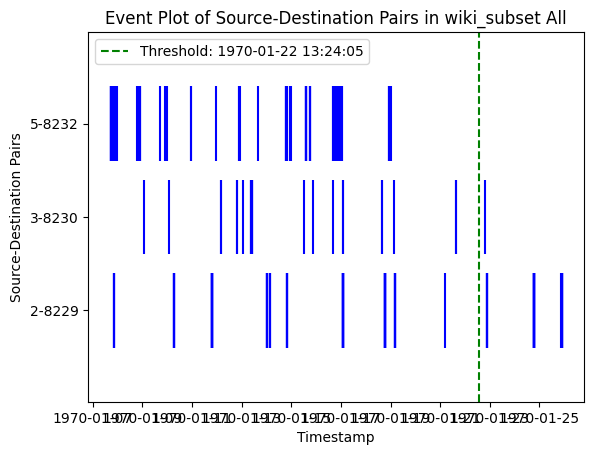

In [147]:
plot_recurrent_samples(recurrent_data_df, 'wiki_subset', 'all', validation_threshold_timestamp)

In [48]:
recurrent_data_df

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek
12869,2,8229,1970-01-07 20:33:32,30760,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11
12870,2,8229,1970-01-07 20:36:21,30781,1.0,"[-0.1271090099980777, -0.1301689930028039, -0....",1970-01-05/1970-01-11
12871,2,8229,1970-01-07 20:43:16,30827,1.0,"[-0.1609585406261295, -0.1611747601253605, -0....",1970-01-05/1970-01-11
12872,2,8229,1970-01-07 20:44:13,30837,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11
12873,2,8229,1970-01-10 06:10:52,43807,1.0,"[-0.1440337753121036, -0.1456718765640822, -0....",1970-01-05/1970-01-11
...,...,...,...,...,...,...,...
40607,4603,9054,1970-01-24 00:46:33,119264,1.0,"[0.8940184972814853, 0.8899207453293089, 1.167...",1970-01-19/1970-01-25
40608,4603,9054,1970-01-24 01:50:57,119477,1.0,"[1.0350582082317012, 1.0201449672440466, 1.122...",1970-01-19/1970-01-25
40609,4603,9054,1970-01-24 01:57:11,119505,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
40610,4603,9054,1970-01-25 00:55:47,124837,1.0,"[0.4173042742697556, 0.4434376987644935, 0.851...",1970-01-19/1970-01-25


## Post Hoc analysis of wiki subset dataset to test for recurrency outside of context window 

In [57]:

# Group by Source and count unique Destinations
source_diversity = recurrent_data_df.groupby('source')['destination'].nunique().reset_index(name='UniqueDestinations')

# Group by Destination and count unique Sources
destination_diversity = recurrent_data_df.groupby('destination')['source'].nunique().reset_index(name='UniqueSources')

# Identify the Source with the most diverse Destinations
most_diverse_source = source_diversity.loc[source_diversity['UniqueDestinations'].idxmax()]

# Identify the Destination linked with the most diverse Sources
most_diverse_destination = destination_diversity.loc[destination_diversity['UniqueSources'].idxmax()]

print(f"Source with the most diverse destinations: {most_diverse_source['source']} ({most_diverse_source['UniqueDestinations']} unique destinations)")
print(f"Destination with the most diverse sources: {most_diverse_destination['destination']} ({most_diverse_destination['UniqueSources']} unique sources)")

Source with the most diverse destinations: 335 (14 unique destinations)
Destination with the most diverse sources: 8411 (30 unique sources)


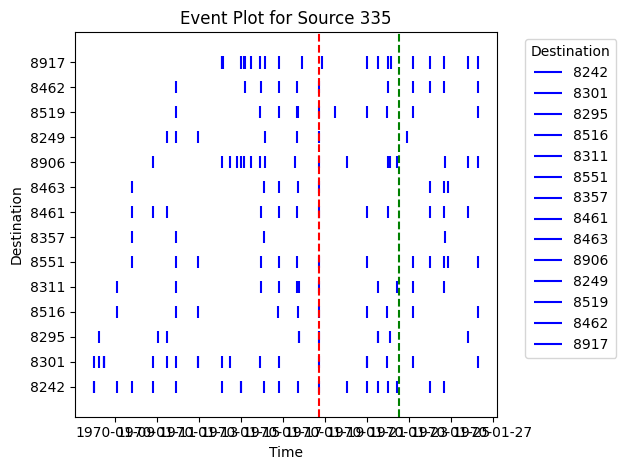

In [65]:

# Specify the source and the specific point in time
context_window = 32

chosen_source = 335
specific_point_in_time = validation_threshold_timestamp

# Filter for the chosen source and interactions up to the specific point in time
filtered_df = recurrent_data_df[(recurrent_data_df['source'] == chosen_source) & (recurrent_data_df['timestamp'] <= specific_point_in_time)]

# Sort by timestamp and take the last 32 interactions
last_context_interactions = filtered_df.sort_values(by='timestamp', ascending=False).head(context_window)
earliest_context_timestamp = last_context_interactions['timestamp'].min()

# Full dataset plot preparation
full_dataset = recurrent_data_df[recurrent_data_df['source'] == chosen_source].sort_values(by='timestamp')
unique_destinations = full_dataset['destination'].unique()
destination_mapping = {dest: i for i, dest in enumerate(unique_destinations)}

# Event plot
fig, ax = plt.subplots()
for destination in unique_destinations:
    destination_interactions = full_dataset[full_dataset['destination'] == destination]
    ax.eventplot(destination_interactions['timestamp'], lineoffsets=destination_mapping[destination], linelengths=0.5, color='blue', label=destination)

# Formatting plot
ax.set_title(f'Event Plot for Source {chosen_source}')
ax.set_xlabel('Time')
ax.set_ylabel('Destination')
ax.set_yticks(range(len(unique_destinations)))
ax.set_yticklabels(unique_destinations)
ax.legend(title='Destination', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axvline(x=validation_threshold_timestamp, color='green', linestyle='--', label=f'Threshold: {validation_threshold_timestamp}')
ax.axvline(x=earliest_context_timestamp, color='red', linestyle='--', label=f'context_window: {earliest_context_timestamp}')

plt.tight_layout()
plt.show()

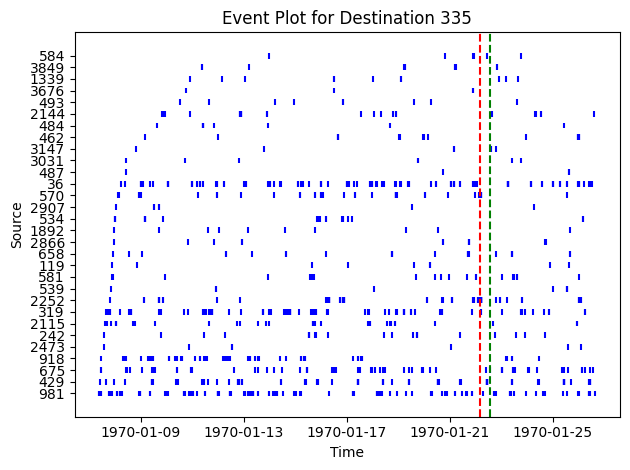

In [64]:

# Specify the source and the specific point in time
context_window = 32

chosen_destination = 8411
specific_point_in_time = validation_threshold_timestamp

# Filter for the chosen source and interactions up to the specific point in time
filtered_df = recurrent_data_df[(recurrent_data_df['destination'] == chosen_destination) & (recurrent_data_df['timestamp'] <= specific_point_in_time)]

# Sort by timestamp and take the last 32 interactions
last_context_interactions = filtered_df.sort_values(by='timestamp', ascending=False).head(context_window)
earliest_context_timestamp = last_context_interactions['timestamp'].min()

# Full dataset plot preparation
full_dataset = recurrent_data_df[recurrent_data_df['destination'] == chosen_destination].sort_values(by='timestamp')
unique_sources = full_dataset['source'].unique()
source_mapping = {sourc: i for i, sourc in enumerate(unique_sources)}

# Event plot
fig, ax = plt.subplots()
for source in unique_sources:
    source_interactions = full_dataset[full_dataset['source'] == source]
    ax.eventplot(source_interactions['timestamp'], lineoffsets=source_mapping[source], linelengths=0.5, color='blue', label=source)

# Formatting plot
ax.set_title(f'Event Plot for Destination {chosen_source}')
ax.set_xlabel('Time')
ax.set_ylabel('Source')
ax.set_yticks(range(len(unique_sources)))
ax.set_yticklabels(unique_sources)
#ax.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axvline(x=validation_threshold_timestamp, color='green', linestyle='--', label=f'Threshold: {validation_threshold_timestamp}')
ax.axvline(x=earliest_context_timestamp, color='red', linestyle='--', label=f'context_window: {earliest_context_timestamp}')


plt.tight_layout()
plt.show()

In [43]:
recurrent_data_df.sort_values(['source', 'timestamp'], inplace=True)
training_recurrent_df = recurrent_data_df[recurrent_data_df['timestamp']< validation_threshold_timestamp]
training_recurrent_df.sort_values('timestamp', ascending=True, inplace=True)
training_recurrent_df

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_19667/3189353079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_recurrent_df.sort_values('timestamp', ascending=True, inplace=True)


,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek
0,1087,8832,1970-01-07 06:55:17,27688,1.0,"[-0.1496753637501123, -0.1487724532763378, 1.3...",1970-01-05/1970-01-11
252,134,8340,1970-01-07 06:55:39,27690,1.0,"[-0.1242882157790734, -0.1270684162905482, 1.1...",1970-01-05/1970-01-11
1,1087,8832,1970-01-07 06:55:50,27691,1.0,"[-0.1581377464071252, -0.1580741834131048, 1.2...",1970-01-05/1970-01-11
1141,289,8442,1970-01-07 06:56:02,27694,1.0,"[0.1972823251874187, 0.2294979056188528, 0.840...",1970-01-05/1970-01-11
1186,2289,8894,1970-01-07 06:56:19,27696,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11
...,...,...,...,...,...,...,...
37867,716,8865,1970-01-22 13:22:57,110223,1.0,"[0.0647049968942158, 0.0744690700060697, 0.964...",1970-01-19/1970-01-25
39364,3404,8962,1970-01-22 13:23:37,110225,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
23627,353,8370,1970-01-22 13:23:41,110226,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
4513,894,8661,1970-01-22 13:23:58,110227,1.0,"[-0.1412129810930993, -0.1394707231395709, 1.1...",1970-01-19/1970-01-25


In [40]:
last_32_dests

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek
21633,716,8436,1970-01-22 13:23:59,110229,1.0,"[-0.1581377464071252, -0.1580741834131048, 1.2...",1970-01-19/1970-01-25
37867,716,8865,1970-01-22 13:22:57,110223,1.0,"[0.0647049968942158, 0.0744690700060697, 0.964...",1970-01-19/1970-01-25
24568,3200,8506,1970-01-22 13:19:54,110211,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
24567,3200,8506,1970-01-22 13:19:22,110208,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
10089,1785,8771,1970-01-22 13:14:23,110198,1.0,"[-0.1637793348451338, -0.1642753368376162, 1.0...",1970-01-19/1970-01-25
...,...,...,...,...,...,...,...
1186,2289,8894,1970-01-07 06:56:19,27696,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11
1141,289,8442,1970-01-07 06:56:02,27694,1.0,"[0.1972823251874187, 0.2294979056188528, 0.840...",1970-01-05/1970-01-11
1,1087,8832,1970-01-07 06:55:50,27691,1.0,"[-0.1581377464071252, -0.1580741834131048, 1.2...",1970-01-05/1970-01-11
252,134,8340,1970-01-07 06:55:39,27690,1.0,"[-0.1242882157790734, -0.1270684162905482, 1.1...",1970-01-05/1970-01-11


In [46]:

last_32_dests = training_recurrent_df.groupby('source').tail(context_window)
unique_source_dests = last_32_dests.drop_duplicates(subset=['source', 'destination'], keep='last')
unique_source_dests

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek
18814,233,8343,1970-01-14 08:08:31,65172,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18
40503,53,8442,1970-01-14 09:16:41,65388,1.0,"[0.1154792928362935, 0.1302794508266717, 0.659...",1970-01-12/1970-01-18
35463,3880,8762,1970-01-14 13:52:43,66334,1.0,"[-0.1524961579691166, -0.1518730299885935, 1.2...",1970-01-12/1970-01-18
30604,3540,9007,1970-01-14 14:43:04,66574,1.0,"[0.2678021806625267, 0.2729059795904321, 0.511...",1970-01-12/1970-01-18
37032,4143,8628,1970-01-14 14:43:36,66577,1.0,"[0.0534218200181985, 0.0682679165815584, 0.934...",1970-01-12/1970-01-18
...,...,...,...,...,...,...,...
37867,716,8865,1970-01-22 13:22:57,110223,1.0,"[0.0647049968942158, 0.0744690700060697, 0.964...",1970-01-19/1970-01-25
39364,3404,8962,1970-01-22 13:23:37,110225,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
23627,353,8370,1970-01-22 13:23:41,110226,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
4513,894,8661,1970-01-22 13:23:58,110227,1.0,"[-0.1412129810930993, -0.1394707231395709, 1.1...",1970-01-19/1970-01-25


In [47]:

n = 4
final_result = pd.DataFrame()

for _, row in unique_source_dests.iterrows():
    source = row['source']
    destination = row['destination']
    
    # Filter original DataFrame for the current source-destination pair
    temp_df = training_recurrent_df[(training_recurrent_df['source'] == source) & (training_recurrent_df['destination'] == destination)]
    
    # Sort by timestamp to ensure correct order
    temp_df = temp_df.sort_values(by='timestamp')
    
    # Get the last n records
    last_n_records = temp_df.tail(n)
    
    # Append to the final result
    final_result = pd.concat([final_result, last_n_records])

# Reset index of the final result for clarity
final_result.reset_index(drop=True, inplace=True)

final_result

,source,destination,timestamp,edge_idxs,edge_label,edge_feat,YearWeek
0,233,8343,1970-01-08 05:51:09,32882,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-05/1970-01-11
1,233,8343,1970-01-14 08:08:31,65172,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18
2,53,8442,1970-01-14 00:20:54,63819,1.0,"[0.1154792928362935, 0.1302794508266717, 0.659...",1970-01-12/1970-01-18
3,53,8442,1970-01-14 09:16:41,65388,1.0,"[0.1154792928362935, 0.1302794508266717, 0.659...",1970-01-12/1970-01-18
4,3880,8762,1970-01-13 16:02:53,61901,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18
...,...,...,...,...,...,...,...
3469,894,8661,1970-01-22 13:23:58,110227,1.0,"[-0.1412129810930993, -0.1394707231395709, 1.1...",1970-01-19/1970-01-25
3470,716,8436,1970-01-17 12:18:56,82886,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-12/1970-01-18
3471,716,8436,1970-01-22 09:00:25,109463,1.0,"[-0.1750625117211511, -0.1766776436866388, -0....",1970-01-19/1970-01-25
3472,716,8436,1970-01-22 09:01:01,109466,1.0,"[-0.1666001290641382, -0.1673759135498718, -0....",1970-01-19/1970-01-25


## SYNTHETIC DATASET TO TEST OUT OF CONTEXT RECURRENCY

### Let's check what's needed to make a synthetic dataset


In [141]:
pathname = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_wiki/ml_tgbl-wiki_edge.pkl'
with open(pathname, 'rb') as file:
    wiki_edge = pickle.load(file)

wiki_edge.shape

(157474, 172)

In [15]:
pathname = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_wiki/ml_tgbl-wiki.pkl'
with open(pathname, 'rb') as file:
    wiki_data = pickle.load(file)

wiki_data

,u,i,ts,idx,w
0,0,8227,0.0,0,1.0
1,1,8228,36.0,1,1.0
2,1,8228,77.0,2,1.0
3,2,8229,131.0,3,1.0
4,1,8228,150.0,4,1.0
...,...,...,...,...,...
157469,2003,8859,2678155.0,157469,1.0
157470,3762,9025,2678158.0,157470,1.0
157471,2399,8722,2678293.0,157471,1.0
157472,7479,9147,2678333.0,157472,1.0


In [13]:
wiki_edge_list = pd.read_csv('/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_wiki/tgbl-wiki_edgelist_v2.csv')

wiki_edge_list

user_id  \
0    0   0.0       0 -0.175063 -0.176678 -0.937091 -0.381926 0.0 -0.636535  1.052396 -0.169380 -0.193040 -0.169234 -0.828942 -0.175093 -0.239675 -0.081759 -0.438492 -0.265227 -0.270534 -0.766241 -0.230818 -0.208397 -0.031458 -0.146052 -0.125919 -0.114999 -0.073666 -0.080377 -0.039977 -0.086417 -0.07646 -0.115336 -0.112976 -0.129556 -0.114021 -0.126911 -0.112939 -0.08632 -0.12648 -0.140237 -0.127462 -0.101234 -0.128890 -0.12375 -0.036678 -0.132163 -0.091828 -0.076866 -0.083422 -0.132653 -0.132271 -0.113523 -0.082894 -0.100532 -0.075784 -0.143635 -0.127528 -0.128455 -0.099046 -0.112457 -0.118284 -0.105322 -0.117228 -0.105303 -0.130077 -0.117335 -0.100452 -0.082987 -0.109775 -0.082519 -0.090150 -0.061807 -0.076595 -0.154405 -0.133709 -0.149318 -0.147526 -0.157631 -0.133908 -0.142128 -0.101243 -0.094235 -0.084585 -0.089205 -0.05786 -0.067859 -0.055429 -0.052329 -0.085588 -0.084010  1.756454 -0.289939 0.0 -0.417990 -1.410948 -0.109215 -0.122009 -0.040390  1.825762 -0.120957 -0.175118 -0.062041 -0.265922 -0.108335 -0.118516  1.196213 -0.151928 -0.143451 -0.009262 -0.103378 -0.089099 -0.081998 -0.052605 -0.0557 -0.030846 -0.060957 -0.053846 -0.081624 -0.078441 -0.087999 -0.079429 -0.088813 -0.071986 -0.065387 -0.089995 -0.097408 -0.093064 -0.076343 -0.086655 -0.085351 -0.036412 -0.087365 -0.059447 -0.053389 -0.055685 -0.087141 -0.089251 -0.073396 -0.058741 -0.06799 -0.038718 -0.097449 -0.087578 -0.090969 -0.072003 -0.081238 -0.081747 -0.068767 -0.087579 -0.075662 -0.082675 -0.07205 -0.068462 -0.045573 -0.073261 -0.053124 -0.06232 -0.04988 -0.0506 -0.105394 -0.090395 -0.099816 -0.102888 -0.102903 -0.090115 -0.096068 -0.068136 -0.060835 -0.058394 -0.062079   
1    1   36.0      0 -0.175063 -0.176678 -0.937091 -0.381926 0.0 -0.636535  1.052396 -0.169380 -0.193040 -0.169234 -0.828942 -0.175093 -0.239675 -0.081759 -0.438492 -0.265227 -0.270534 -0.766241 -0.230818 -0.208397 -0.031458 -0.146052 -0.125919 -0.114999 -0.073666 -0.080377 -0.039977 -0.086417 -0.07646 -0.115336 -0.112976 -0.129556 -0.114021 -0.126911 -0.112939 -0.08632 -0.12648 -0.140237 -0.127462 -0.101234 -0.128890 -0.12375 -0.036678 -0.132163 -0.091828 -0.076866 -0.083422 -0.132653 -0.132271 -0.113523 -0.082894 -0.100532 -0.075784 -0.143635 -0.127528 -0.128455 -0.099046 -0.112457 -0.118284 -0.105322 -0.117228 -0.105303 -0.130077 -0.117335 -0.100452 -0.082987 -0.109775 -0.082519 -0.090150 -0.061807 -0.076595 -0.154405 -0.133709 -0.149318 -0.147526 -0.157631 -0.133908 -0.142128 -0.101243 -0.094235 -0.084585 -0.089205 -0.05786 -0.067859 -0.055429 -0.052329 -0.114147 -0.115286 -0.649615 -0.289939 0.0 -0.417990  0.723261 -0.109215 -0.122009 -0.109234 -0.559786 -0.120957 -0.175118 -0.062041 -0.265922 -0.155394 -0.157044 -0.515898 -0.151928 -0.143451 -0.009262 -0.103378 -0.089099 -0.081998 -0.052605 -0.0557 -0.030846 -0.060957 -0.053846 -0.081624 -0.078441 -0.087999 -0.079429 -0.088813 -0.071986 -0.065387 -0.089995 -0.097408 -0.093064 -0.076343 -0.086655 -0.085351 -0.036412 -0.087365 -0.059447 -0.053389 -0.055685 -0.087141 -0.089251 -0.073396 -0.058741 -0.06799 -0.038718 -0.097449 -0.087578 -0.090969 -0.072003 -0.081238 -0.081747 -0.068767 -0.087579 -0.075662 -0.082675 -0.07205 -0.068462 -0.045573 -0.073261 -0.053124 -0.06232 -0.04988 -0.0506 -0.105394 -0.090395 -0.099816 -0.102888 -0.102903 -0.090115 -0.096068 -0.068136 -0.060835 -0.058394 -0.062079   
         77.0      0 -0.175063 -0.176678 -0.937091 -0.381926 0.0 -0.636535  1.052396 -0.169380 -0.193040 -0.169234 -0.828942 -0.175093 -0.239675 -0.081759 -0.438492 -0.265227 -0.270534 -0.766241 -0.230818 -0.208397 -0.031458 -0.146052 -0.125919 -0.114999 -0.073666 -0.080377 -0.039977 -0.086417 -0.07646 -0.115336 -0.112976 -0.129556 -0.114021 -0.126911 -0.112939 -0.08632 -0.12648 -0.140237 -0.127462 -0.101234 -0.128890 -0.12375 -0.036678 -0.132163 -0.091828 -0.076866 -0.083422 -0.132653 -0.132271 -0.113523 -0.082894 -0.100532 -0.075784 -0.143635 -0.127528 -0.128455 -0.099046 -0.112457 -0.118284 -0.105322 -0.117228 -0.105303 

In [9]:
neg_samples_path = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_synthetic/tgbl-synthetic_val_ns.pkl'
with open(neg_samples_path, 'rb') as file:
    neg_samples = pickle.load(file)
neg_samples

{(0, 0, 448): array([1, 2, 6, 3, 5, 4, 7]),
 (0, 1, 449): array([6, 0, 4, 3, 2, 7, 5]),
 (0, 2, 450): array([0, 1, 7, 6, 4, 5, 3]),
 (0, 3, 451): array([0, 2, 7, 6, 4, 1, 5]),
 (0, 4, 452): array([6, 2, 1, 7, 0, 5, 3]),
 (0, 5, 453): array([1, 6, 2, 7, 0, 3, 4]),
 (0, 6, 454): array([0, 5, 2, 4, 3, 1, 7]),
 (0, 7, 455): array([0, 1, 4, 3, 2, 6, 5]),
 (1, 0, 449): array([2, 7, 4, 6, 5, 3, 1]),
 (1, 1, 450): array([5, 3, 6, 7, 4, 2, 0]),
 (1, 2, 451): array([4, 3, 5, 6, 7, 0, 1]),
 (1, 3, 452): array([1, 5, 2, 0, 6, 7, 4]),
 (1, 4, 453): array([7, 2, 5, 1, 3, 0, 6]),
 (1, 5, 454): array([2, 0, 4, 3, 1, 7, 6]),
 (1, 6, 455): array([0, 2, 4, 3, 5, 1, 7]),
 (1, 7, 448): array([4, 2, 1, 0, 6, 3, 5]),
 (2, 0, 450): array([4, 6, 1, 3, 2, 7, 5]),
 (2, 1, 451): array([7, 3, 6, 5, 4, 0, 2]),
 (2, 2, 452): array([1, 4, 3, 6, 0, 7, 5]),
 (2, 3, 453): array([6, 1, 7, 5, 2, 4, 0]),
 (2, 4, 454): array([3, 1, 5, 6, 0, 7, 2]),
 (2, 5, 455): array([6, 4, 2, 3, 0, 1, 7]),
 (2, 6, 448): array([5, 4, 2, 7,

### Create synthetic data 

In [276]:

def plot_recurrent_samples(final_df, size, dataset_name, subset_name, validation_timestamp):
    results_df = final_df.copy()
    if len(final_df) > 200:
        #subset = random.sample(range(len(final_df)), 200)
        results_df = results_df.head(size)
    

    # Correct column names for source and destination if needed
    results_df['Source_Destination'] = results_df['source'].astype(str) + "-" + results_df['destination'].astype(str)
    unique_pairs = results_df['Source_Destination'].unique()
    pair_mapping = {pair: i for i, pair in enumerate(unique_pairs)}

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))  
    for pair, group in results_df.groupby('Source_Destination'):
        pair_index = pair_mapping[pair]
        ax.eventplot(group['timestamp'], lineoffsets=pair_index, linelengths=1, colors='blue', orientation='horizontal')

    # Set the y-axis labels to the source-destination pairs
    ax.set_yticks(list(pair_mapping.values()))
    ax.set_yticklabels(list(pair_mapping.keys()), fontsize=10)
    
    ax.set_xlabel('Timestamp', fontsize=12)
    ax.set_ylabel('Source-Destination Pairs', fontsize=12)
    ax.set_title(f'Event Subplot of Source-Destination Pairs \n in {dataset_name} {subset_name.strip("_").capitalize()}')

    # Add a vertical line at the specified timestamp value if in train_val subset
    #if subset_name == '_train_val':
    if validation_timestamp != None:
        ax.axvline(x=validation_timestamp, color='green', linestyle='--', label=f'Threshold: {validation_timestamp}')

    ax.legend()
    save_title = f"{dataset_name}_recurrent_SD{subset_name}.jpg"
    plt.savefig(save_title)
    plt.show()

In [233]:
def rotate_list_and_extend(lst):
    rotations = len(lst) - 1
    rotated_lists = lst

    for i in range(rotations):
        lst = lst[1:] + lst[:1]
        rotated_lists.extend(lst)

    return rotated_lists


context_window = 8
repeat = context_window
num_source = context_window
num_destination = context_window
repeat = context_window*10

source = range(num_source)
destination = range(num_destination)
timestamps = rotate_list_and_extend(list(range(context_window)))

In [234]:

source_list = []
destination_list = []
timestamp_list = []

for rep in range(repeat):
    # Offset for the timestamps on each repetition
    time_offset = rep * context_window
    n = 0
    for s in source:
        for d in destination:
            t = timestamps[n] + time_offset 
            source_list.append(s)
            destination_list.append(d)
            timestamp_list.append(t)
            n+=1




In [281]:
synth_df

,source,destination,timestamp
0,0,0,0
1,0,1,1
2,0,2,2
3,0,3,3
4,0,4,4
...,...,...,...
5115,7,3,634
5116,7,4,635
5117,7,5,636
5118,7,6,637


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


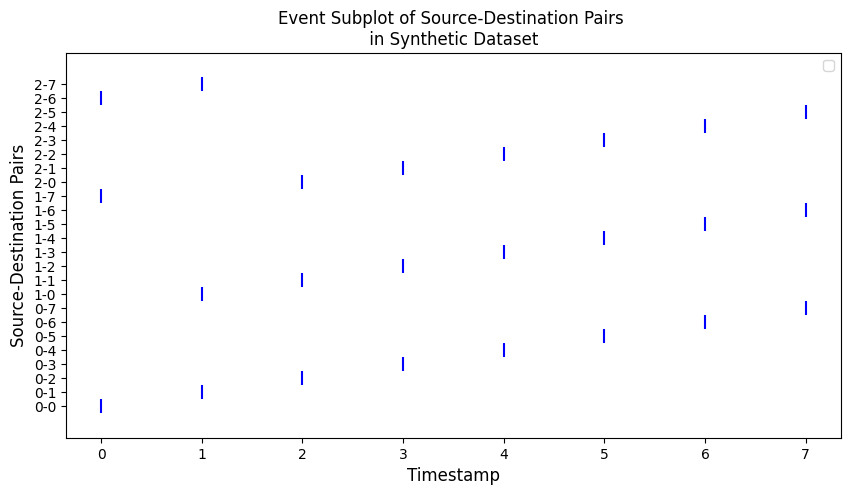

In [280]:

synth_df = pd.DataFrame({
    'source': source_list,
    'destination': destination_list,
    'timestamp': timestamp_list

})
synth_df

plot_recurrent_samples(synth_df, 24, 'Synthetic Dataset', '', None)

In [194]:
synth_df

,source,destination,timestamp
0,0,0,0
1,0,1,1
2,0,2,2
3,0,3,3
4,0,4,4
...,...,...,...
5115,7,3,634
5116,7,4,635
5117,7,5,636
5118,7,6,637


In [ ]:
def plot_interaction_over_time(synth_df, entity_type, chosen_entity, specific_point_in_time, context_window):
    # Determine whether to filter by source or destination
    if entity_type == 'source':
        filter_col = 'source'
        interaction_col = 'destination'
    elif entity_type == 'destination':
        filter_col = 'destination'
        interaction_col = 'source'
    else:
        raise ValueError("entity_type must be either 'source' or 'destination'")
    
    # Filter the dataframe
    filtered_df = synth_df[(synth_df[filter_col] == chosen_entity) & (synth_df['timestamp'] <= specific_point_in_time)]
    
    # Get the last context interactions
    last_context_interactions = filtered_df.sort_values(by='timestamp', ascending=False).head(context_window)
    earliest_context_timestamp = last_context_interactions['timestamp'].min()

    # Full dataset preparation for plotting
    full_dataset = synth_df[synth_df[filter_col] == chosen_entity].sort_values(by='timestamp')
    unique_interactions = full_dataset[interaction_col].unique()
    interaction_mapping = {entity: i for i, entity in enumerate(unique_interactions)}

    # Plotting
    fig, ax = plt.subplots()
    for entity in unique_interactions:
        entity_interactions = full_dataset[full_dataset[interaction_col] == entity]
        ax.eventplot(entity_interactions['timestamp'], lineoffsets=interaction_mapping[entity], linelengths=0.5, color='blue', label=entity)
    
    # Formatting plot
    title = f'Event Plot for {entity_type.capitalize()} {chosen_entity}'
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel(interaction_col.capitalize())
    ax.set_yticks(range(len(unique_interactions)))
    ax.set_yticklabels(unique_interactions)
    # Uncomment the following line if you want to display the legend
    # ax.legend(title=interaction_col.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.axvline(x=specific_point_in_time, color='green', linestyle='--', label=f'Threshold: {specific_point_in_time}')
    ax.axvline(x=earliest_context_timestamp, color='red', linestyle='--', label=f'Context window start: {earliest_context_timestamp}')

    plt.tight_layout()
    plt.show()

# Usage:
plot_interaction_over_time(synth_df, 'source', 1,  val_threshold_time_synth, context_window=8)
# plot_interaction_over_time(synth_df, chosen_destination, specific_point_in_time, 'destination')


### Save it to the appropriate places in the appropriate way

In [100]:
base_path = 'TGB/tgb/datasets/tgbl_synthetic/'

synth_df = pd.DataFrame({
    'u': source_list,
    'i': destination_list,
    'ts': timestamp_list

})
synth_df['idx'] = range(0, len(synth_df))
synth_df['w'] = 1.0

with open( base_path + 'ml_tgbl-synthetic.pkl', 'wb') as file: 
    pickle.dump(synth_df, file)


synth_df['edge_label'] = 1.0
 
synth_edge = np.stack(synth_df['edge_label'].apply(lambda x: np.array([x])))
with open( base_path + 'ml_tgbl-synthetic_edge.pkl', 'wb') as file: 
    pickle.dump(synth_edge, file) 


synth_df = pd.DataFrame({
    'user_id': source_list,
    'item_id': destination_list,
    'timestamp': timestamp_list,
    'state_label': 1.0,

})
synth_df['comma_separated_list_of_features'] = 1.0


synth_df.to_csv(base_path + 'tgbl-synthetic_edgelist.csv', index=False)

## Check the results of TGN on the synthetic data


#### plotting functions

In [321]:

class EventPlotter:
    def __init__(self, val_df, synth_df):
        self.val_df = val_df.copy()
        self.synth_df = synth_df.copy()
        self.earliest_timestamp = self.val_df['timestamp'].min()
        self.latest_timestamp = self.val_df['timestamp'].max()


        self.preprocess_data()
        
    def preprocess_data(self):
        """Preprocess the dataframes to include necessary columns for plotting."""
        # Create match keys
        self.val_df['match_key'] = self.val_df.apply(lambda x: f"{x['source']}-{x['destination']}-{x['timestamp']}", axis=1)
        self.synth_df['match_key'] = self.synth_df.apply(lambda x: f"{x['source']}-{x['destination']}-{x['timestamp']}", axis=1)
        
        # Determine matches
        matching_keys_set = set(self.synth_df['match_key'])
        self.val_df['is_match'] = self.val_df['match_key'].isin(matching_keys_set)
        
        # Find top predictions
        top_pred_idx = self.val_df.groupby(['source', 'timestamp'])['scaled_predictions'].idxmax()
        self.val_df['is_top_prediction'] = False
        self.val_df.loc[top_pred_idx, 'is_top_prediction'] = True
        
        # Determine if top predictions are in synth_df
        self.val_df['top_pred_in_synth'] = self.val_df['is_top_prediction'] & self.val_df['is_match']
        
        # Create a unique identifier for each source-destination pair
        self.val_df['source_dest_pair'] = self.val_df.apply(lambda x: f"{x['source']}-{x['destination']}", axis=1)
        
    def plot_source_group(self, source_id=None):
        """Plot events optionally for a specific source group or all sources."""
        # Conditionally filter for the specific source ID if provided
        if source_id is not None:
            val_df_filtered = self.val_df[(self.val_df['source'] == source_id)]
            synth_df_filtered = self.synth_df[(self.synth_df['source'] == source_id)]
        else:
            val_df_filtered = self.val_df.copy()
            synth_df_filtered = self.synth_df.copy()

        # Apply timestamp filtering
        if self.earliest_timestamp is not None and self.latest_timestamp is not None:
            val_df_filtered = val_df_filtered[(val_df_filtered['timestamp'] >= self.earliest_timestamp) & (val_df_filtered['timestamp'] <= self.latest_timestamp)]
            synth_df_filtered = synth_df_filtered[(synth_df_filtered['timestamp'] >= self.earliest_timestamp) & (synth_df_filtered['timestamp'] <= self.latest_timestamp)]

        unique_pairs = val_df_filtered['source_dest_pair'].unique()
    
        pair_to_y = {pair: i for i, pair in enumerate(unique_pairs)}
        #pair_to_y = {pair: i for i, pair in enumerate(sorted_pairs)}
        
        fig, ax = plt.subplots(figsize=(12, 8))


        # Plotting actual events from synth_df in orange
        for pair, y_value in pair_to_y.items():
            source, destination = map(int, pair.split('-'))
            actual_events = synth_df_filtered[(synth_df_filtered['source'] == source) & (synth_df_filtered['destination'] == destination)]
            ax.eventplot(actual_events['timestamp'], lineoffsets=[y_value], linelengths=0.5, color='orange', alpha=0.7, linestyle='dotted')


        # Plotting predictions from val_results_TGN_synthetic_df as before
        # Corrected plotting predictions section
        for pair, y_value in pair_to_y.items():
            pair_events = val_df_filtered[val_df_filtered['source_dest_pair'] == pair]
            
            # Other predictions in gray
            other_events = pair_events[~pair_events['is_top_prediction'] | (pair_events['is_top_prediction'] & ~pair_events['is_match'])]
            ax.eventplot(other_events['timestamp'], lineoffsets=[y_value], linelengths=0.5, color='gray', alpha=0.3)
            
            # Top predictions in synth_df in green
            top_in_synth = pair_events[pair_events['top_pred_in_synth']]
            ax.eventplot(top_in_synth['timestamp'], lineoffsets=[y_value], linelengths=0.5, color='green', alpha=0.9)
            
            # Top predictions not in synth_df in red
            top_not_in_synth = pair_events[~pair_events['top_pred_in_synth'] & pair_events['is_top_prediction']]
            ax.eventplot(top_not_in_synth['timestamp'], lineoffsets=[y_value], linelengths=0.5, color='red', alpha=0.9)

        legend_handles = [
            Line2D([0], [0], color='gray', lw=4, label='Predictions (Not Top)', alpha=0.3),
            Line2D([0], [0], color='green', lw=4, label='Top Predictions (Matched in Synth)'),
            Line2D([0], [0], color='red', lw=4, label='Top Predictions (Not Matched)'),
            Line2D([0], [0], color='orange', lw=4, label='Actual Events from Synth (Filtered)', linestyle='dotted', alpha=0.7)
        ]

        # Formatting the plot
        ax.set_title('Event Plot with Predictions and Actual Events (Filtered)')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Source-Destination Pair')
        ax.set_yticks(range(len(unique_pairs)))
        ax.set_yticklabels(unique_pairs, fontsize=8)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.legend(handles=legend_handles, loc='best')

        plt.show()

    

In [322]:

def preprocess_and_identify_matches(val_df, synth_df):
    
    val_df['source'] = val_df['source'].astype(int)
    val_df['destination'] = val_df['destination'].astype(int)
    val_df['timestamp'] = val_df['timestamp'].astype(int)

    synth_df['source'] = synth_df['source'].astype(int)
    synth_df['destination'] = synth_df['destination'].astype(int)
    synth_df['timestamp'] = synth_df['timestamp'].astype(int)
    #val_df = val_df.copy()
    #synth_df = synth_df.copy()

    # Step 1: Ensure correct data types (if necessary, adjust according to your specific dataframe)
    # For illustrative purposes, let's assume the types are already compatible or have been handled prior.
    
    # Step 2: Create match keys in both DataFrames
    val_df['match_key'] = val_df.apply(lambda x: f"{int(x['source'])}-{int(x['destination'])}-{int(x['timestamp'])}", axis=1)
    synth_df['match_key'] = synth_df.apply(lambda x: f"{int(x['source'])}-{int(x['destination'])}-{int(x['timestamp'])}", axis=1)
    
    # Step 3: Determine matches
    matching_keys_set = set(synth_df['match_key'])
    val_df['is_match'] = val_df['match_key'].isin(matching_keys_set)
    
    # Step 4: Identify top predictions
    top_pred_idx = val_df.groupby(['source', 'timestamp'])['scaled_predictions'].idxmax()
    val_df['is_top_prediction'] = False
    val_df.loc[top_pred_idx, 'is_top_prediction'] = True
    
    # Step 5: Determine if top predictions are in synth_df
    val_df['top_pred_in_synth'] = val_df['is_top_prediction'] & val_df['is_match']

    top_predictions_in_synth = val_df[val_df['top_pred_in_synth']]

    # Step 1: Identify all top predictions
    all_top_predictions = val_df[val_df['is_top_prediction']]

    # Step 2: Your already identified correct top predictions
    top_predictions_in_synth = val_df[
        (val_df['is_top_prediction']) & 
        (val_df['is_match'])
    ]

    # Step 3: Calculate the percentage
    percentage_correct_top_predictions = (len(top_predictions_in_synth) / len(all_top_predictions)) * 100

    print(f"Percentage of top predictions that were correct: {percentage_correct_top_predictions:.2f}%")

    return top_predictions_in_synth


#### the Results!!

In [323]:
dyg_former_val_results_path = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/saved_results/DyGFormer/tgbl-synthetic/val_synthetic_validation_data.csv'
graph_mixer_results_path = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/saved_results/GraphMixer/tgbl-synthetic/test_synthetic_validation_data.csv'
tgn_results_path = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/synthetic_validation_data.csv'
val_results_synthetic_df = pd.read_csv(tgn_results_path)
val_results_synthetic_df['scaled_predictions'] = val_results_synthetic_df.groupby(['source', 'timestamp'])['predictions'].transform(lambda x: x / x.sum())
val_results_synthetic_df


,source,destination,timestamp,predictions,scaled_predictions
0,0,0,448,9.999939e-01,9.999913e-01
1,0,1,448,3.260028e-08,3.260019e-08
2,0,2,448,4.136392e-20,4.136381e-20
3,0,6,448,1.923696e-07,1.923691e-07
4,0,3,448,3.529301e-24,3.529292e-24
...,...,...,...,...,...
6139,7,0,542,4.786232e-01,3.237282e-01
6140,7,4,542,1.769645e-20,1.196942e-20
6141,7,1,542,2.693541e-14,1.821841e-14
6142,7,3,542,1.562083e-26,1.056552e-26


In [324]:
top_predictions_in_synth = preprocess_and_identify_matches(val_results_synthetic_df, synth_df)

top_predictions_in_synth

Percentage of top predictions that were correct: 67.19%


,source,destination,timestamp,predictions,scaled_predictions,match_key,is_match,is_top_prediction,top_pred_in_synth
0,0,0,448,0.999994,0.999991,0-0-448,True,True,True
8,0,1,449,1.000000,0.999999,0-1-449,True,True,True
16,0,2,450,0.999999,0.999994,0-2-450,True,True,True
24,0,3,451,1.000000,1.000000,0-3-451,True,True,True
32,0,4,452,1.000000,0.999962,0-4-452,True,True,True
...,...,...,...,...,...,...,...,...,...
6064,6,6,540,1.000000,0.999999,6-6-540,True,True,True
6072,6,7,541,1.000000,0.998505,6-7-541,True,True,True
6080,7,0,543,0.999985,0.999953,7-0-543,True,True,True
6088,7,1,536,1.000000,0.999999,7-1-536,True,True,True


/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_91790/3346810662.py:59: MatplotlibDeprecationWarning: "linestyle" keyword argument will be ignored
  ax.eventplot(actual_events['timestamp'], lineoffsets=[y_value], linelengths=0.5, color='orange', alpha=0.7, linestyle='dotted')


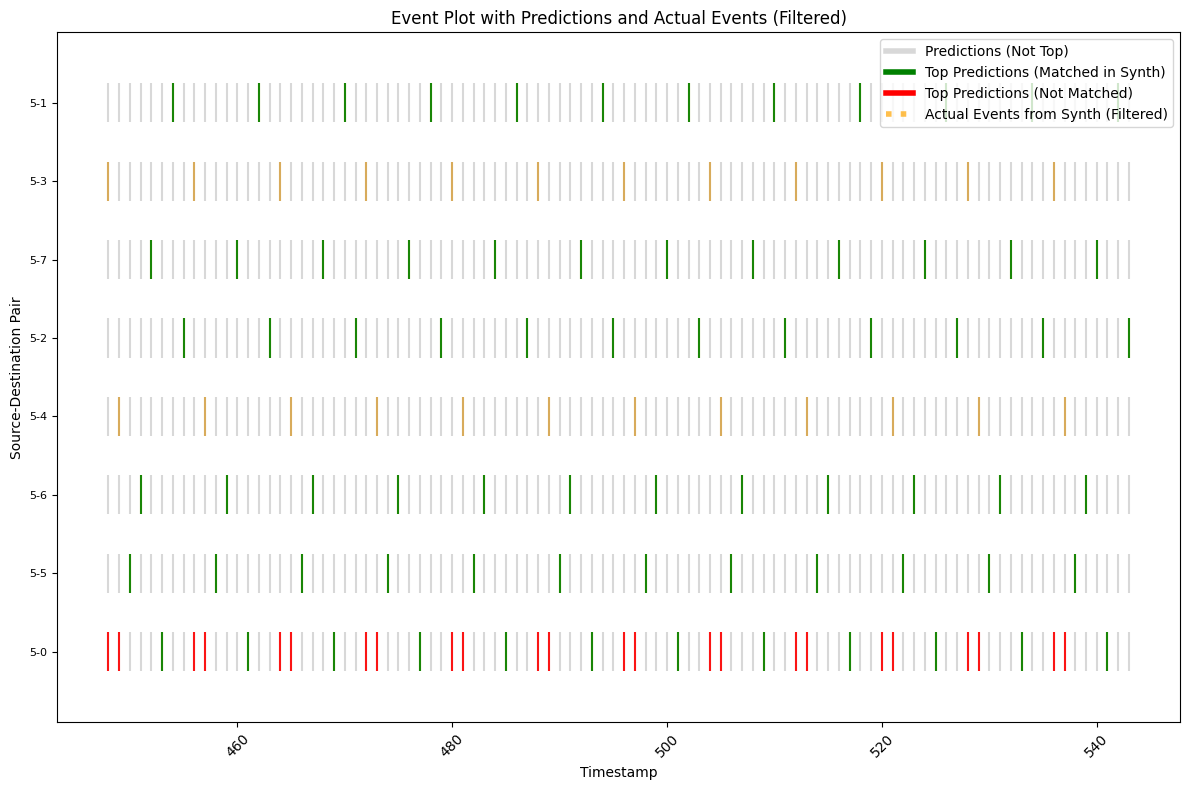

In [325]:
plotter = EventPlotter(val_results_synthetic_df, synth_df)

plotter.plot_source_group(source_id=5)


In [285]:
np.std([0.4633, 0.4772, 0.4706])

0.005677049311824674

In [287]:
np.std([ 0.7632, 0.7616, 0.7630])

0.000711805216802061